# California Housing Dataset

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/ml/blob/main/notebooks/california_housing.ipynb)
[![Render nbviewer](https://img.shields.io/badge/render-nbviewer-f37726)](https://nbviewer.org/github/adamelliotfields/ml/blob/main/notebooks/california_housing.ipynb)

One of the most popular datasets for regression. The dataset contains 20640 instances and 8 features. The target variable is the median house value for a California census block from 1990.

The dataset was originally in the [StatLib](https://lib.stat.cmu.edu) dataset repository and it also made an appearance in the [Hands-On Machine Learning](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow-ebook/dp/B0BHCFNY9Q/) book.

This notebook includes:
  * EDA including Folium heat map
  * Feature importances with Yellowbrick
  * SHAP summary plot
  * Robust scaling with Yeo-Johnson transformation
  * MLP pipeline

In [1]:
import sys
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from importlib.util import find_spec
from folium import Map
from folium.plugins import HeatMap
from scipy.stats import yeojohnson
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, RobustScaler, StandardScaler
from yellowbrick.model_selection import FeatureImportances

if not find_spec("shap"):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "shap"])

from shap import TreeExplainer, sample, summary_plot

## Data

From the Google [ML Course](https://developers.google.com/machine-learning/crash-course/california-housing-data-description):

* `MedInc`: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
* `HouseAge`: Median age of a house within a block; a lower number is a newer building
* `AveRooms`: Total number of rooms within a block
* `AveBedrms`: Total number of bedrooms within a block
* `Population`: Total number of people residing within a block
* `AveOccup`: Total number of households, a group of people residing within a home unit, for a block
* `Latitude`: A measure of how far north a house is; a higher value is farther north
* `Longitude`: A measure of how far west a house is; a more negative value is farther west
* `MedHouseVal`: Median house value for households within a block (measured in hundreds of thousands of US Dollars)

In [2]:
# set `SCIKIT_LEARN_DATA` to cache
housing = fetch_california_housing(as_frame=True)

# concatenate column-wise
housing_df = pd.concat([housing.data, housing.target], axis=1)
housing_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


### Geospatial data

Because we have latitude and longitude, we can plot the data using a scatter plot colored by house value, and a density plot shaded by how populated the area is. For an interactive map, we can use Folium with a heat map overlay.

Along the coast the homes are more expensive; and SoCal and Bay Area are more densely populated.

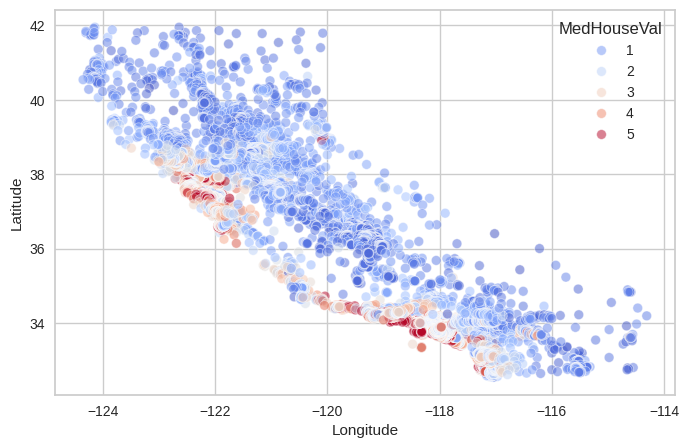

In [3]:
# scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(
    housing_df,
    x="Longitude",
    y="Latitude",
    hue="MedHouseVal",
    palette="coolwarm",
    alpha=0.5,
);

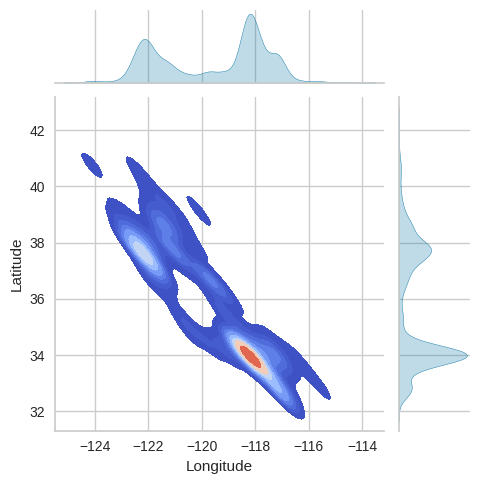

In [4]:
# density plot
sns.jointplot(
    housing_df,
    x="Longitude",
    y="Latitude",
    kind="kde",  # also hex
    cmap="coolwarm",
    height=5,
    ratio=4,
    # fill the kde
    fill=True,
);

In [ ]:
# folium heat map
center = [
    housing_df.Latitude.mean(),
    housing_df.Longitude.mean(),
]

m = Map(location=center, zoom_start=7)
heat_data = [[row.Latitude, row.Longitude] for _, row in housing_df.iterrows()]
HeatMap(heat_data).add_to(m)

m  # render

### Scale and transform

Because the features have different scales, we will need to scale them before training the model. We can use a `StandardScaler` from scikit-learn. After scaling, we can use Yeo-Johnson transformation to make the data more Gaussian-like.

In [5]:
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

X_standard = standard_scaler.fit_transform(housing.data)
X_robust = robust_scaler.fit_transform(housing.data)

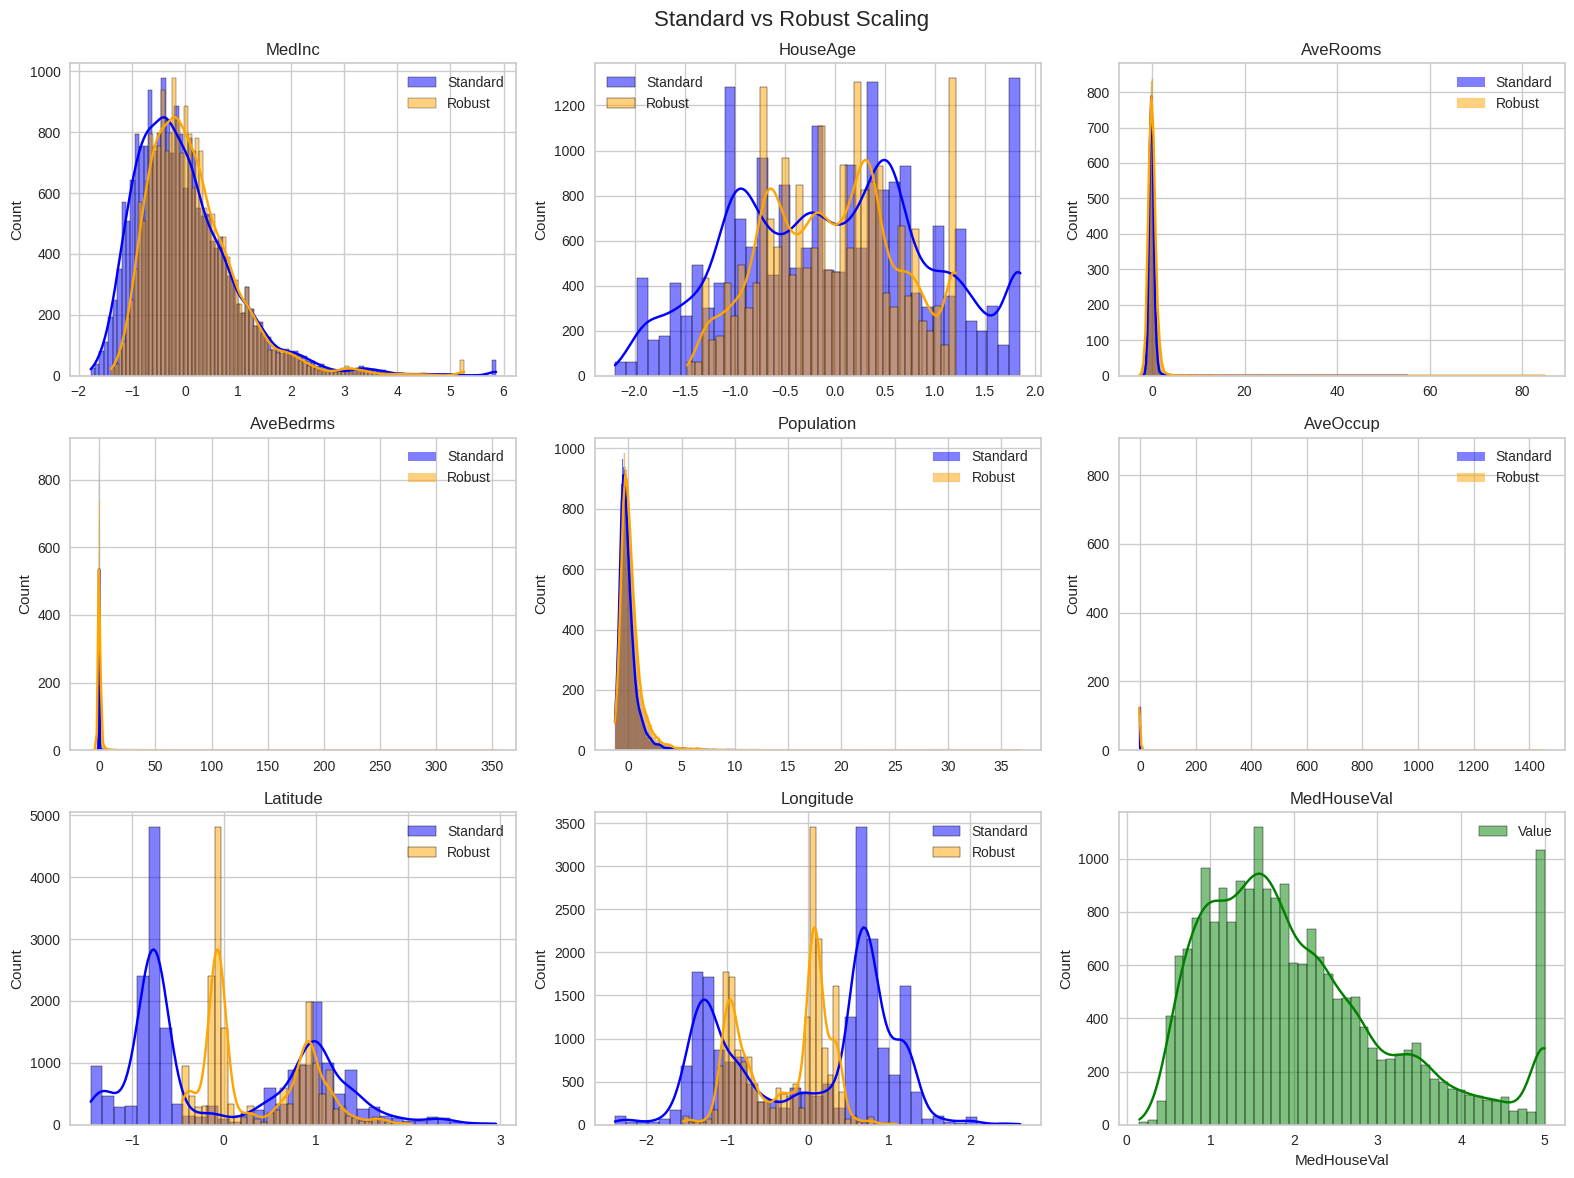

In [6]:
# plot standard vs robust scaling
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
fig.suptitle("Standard vs Robust Scaling", fontsize=16)

for i, col in enumerate(housing_df.columns[:-1]):
    sns.histplot(
        X_standard[:, i],
        kde=True,
        color="blue",
        ax=axes[i // 3, i % 3],
        label="Standard",
    )
    sns.histplot(
        X_robust[:, i],
        kde=True,
        color="orange",
        ax=axes[i // 3, i % 3],
        label="Robust",
    )
    axes[i // 3, i % 3].set_title(col)
    axes[i // 3, i % 3].legend()

# plot house value in green in 9th ax
sns.histplot(
    housing.target,
    kde=True,
    color="green",
    ax=axes[2, 2],
    label="Value",
)
axes[2, 2].set_title("MedHouseVal")
axes[2, 2].legend()
plt.tight_layout();

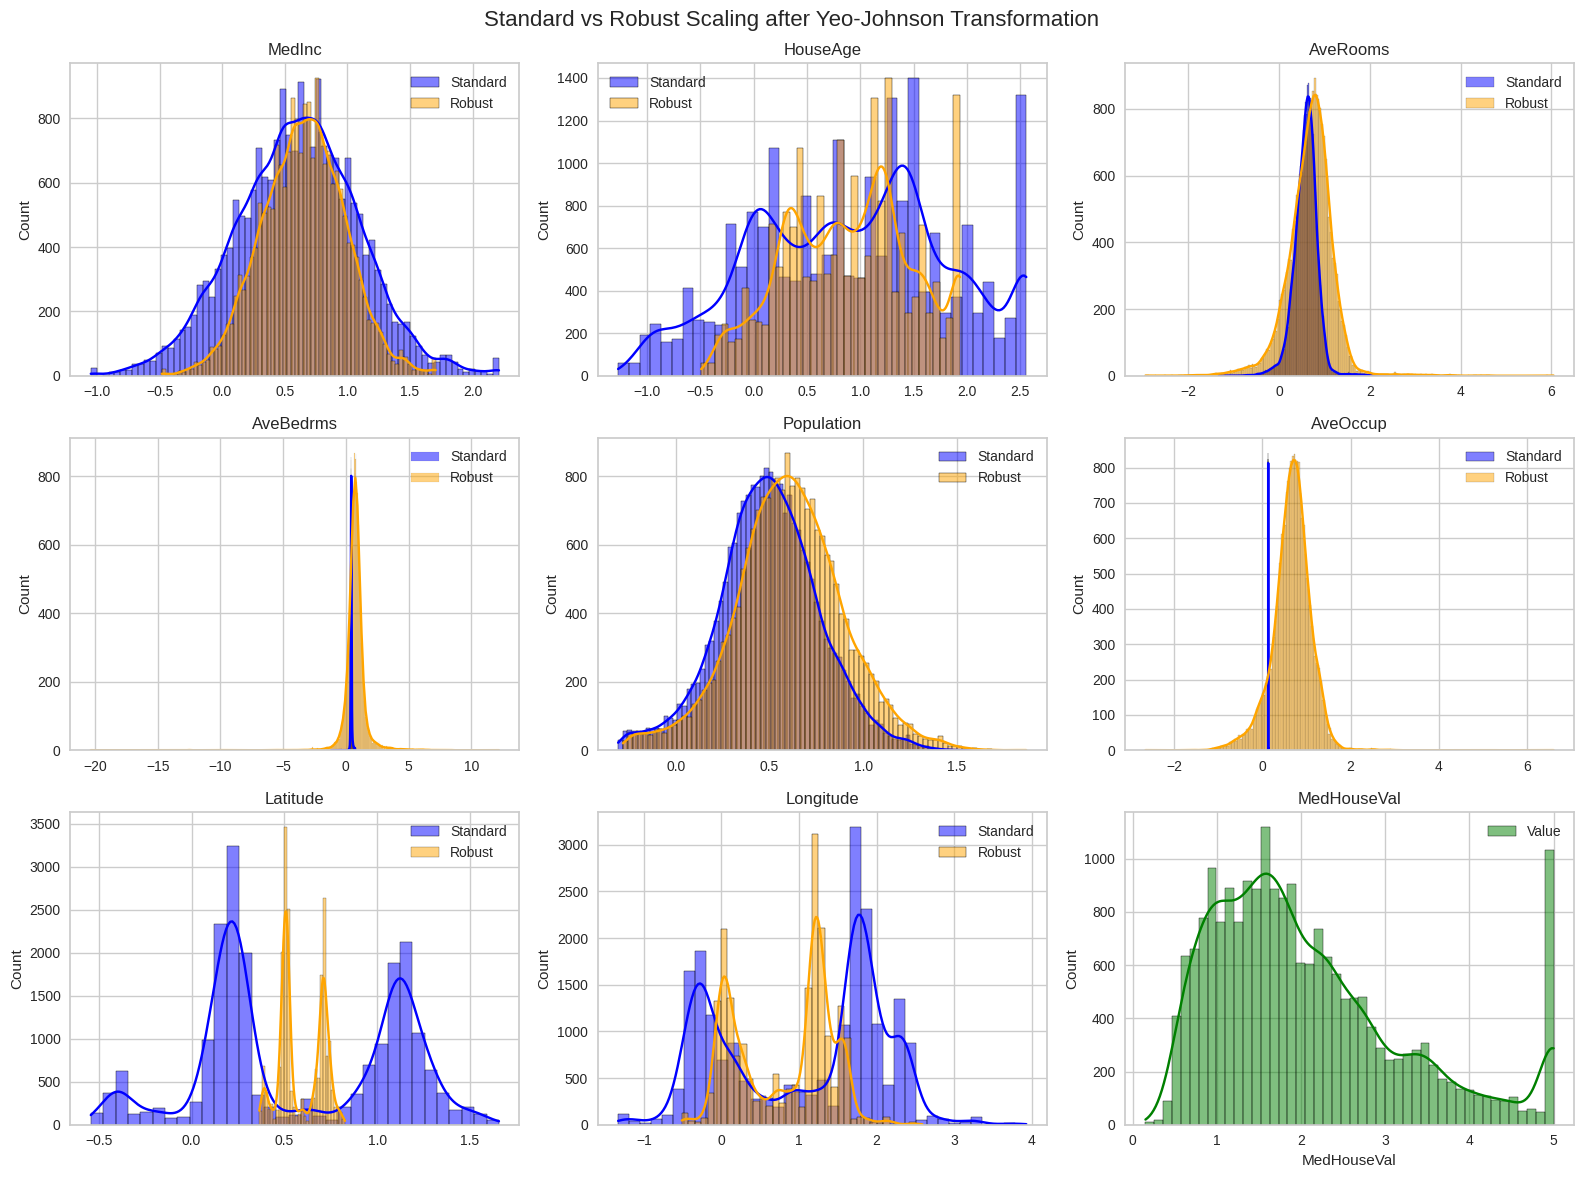

In [7]:
X_standard_trans = X_standard.copy()
X_standard_trans = np.apply_along_axis(
    lambda x: yeojohnson(x + 1)[0],
    arr=X_standard_trans,
    axis=0,
)

X_robust_trans = X_robust.copy()
X_robust_trans = np.apply_along_axis(
    lambda x: yeojohnson(x + 1)[0],
    arr=X_robust_trans,
    axis=0,
)

# replot
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
fig.suptitle("Standard vs Robust Scaling after Yeo-Johnson Transformation", fontsize=16)

for i, col in enumerate(housing_df.columns[:-1]):
    sns.histplot(
        X_standard_trans[:, i],
        kde=True,
        color="blue",
        ax=axes[i // 3, i % 3],
        label="Standard",
    )
    sns.histplot(
        X_robust_trans[:, i],
        kde=True,
        color="orange",
        ax=axes[i // 3, i % 3],
        label="Robust",
    )
    axes[i // 3, i % 3].set_title(col)
    axes[i // 3, i % 3].legend()

# plot house value in green in 9th ax
sns.histplot(
    housing.target,
    kde=True,
    color="green",
    ax=axes[2, 2],
    label="Value",
)
axes[2, 2].set_title("MedHouseVal")
axes[2, 2].legend()
plt.tight_layout();

In [8]:
# random forest regressor for feature importances
X_train, X_test, y_train, y_test = train_test_split(
    housing.data.values,
    housing.target.values,
    test_size=0.2,
    random_state=42,
)

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

In [10]:
y_pred_rf = rf.predict(X_test)
print(f"Test R^2: {r2_score(y_test, y_pred_rf)}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_rf)}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_rf)}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, y_pred_rf)}")

Test R^2: 0.8051230593157366
Test MSE: 0.2553684927247781
Test MAE: 0.32754256845930246
Test MAPE: 0.1891511073211086


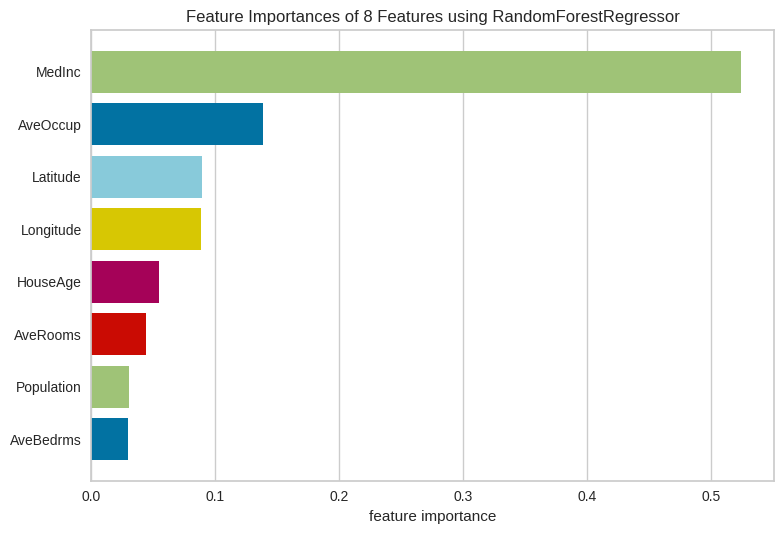

In [11]:
viz = FeatureImportances(
    rf,
    relative=False,
    labels=housing_df.columns[:-1],
)
viz.fit(X_train, y_train)
viz.show();

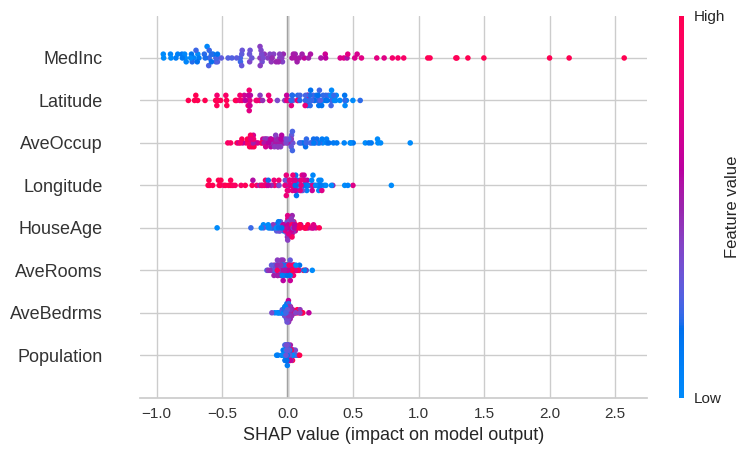

In [12]:
explainer = TreeExplainer(rf)
X_train_sample = sample(X_train, 100)
shap_values = explainer.shap_values(X_train_sample)
summary_plot(shap_values, X_train_sample, feature_names=housing_df.columns[:-1])

In [ ]:
def yeojohnson_transform(x):
    return np.apply_along_axis(lambda x: yeojohnson(x + 1)[0], arr=x, axis=0)


# scale before transform
pipe = make_pipeline(
    RobustScaler(),
    FunctionTransformer(
        func=yeojohnson_transform,
        validate=False,
    ),
    MLPRegressor(
        hidden_layer_sizes=(64, 128),
        learning_rate="adaptive",
        learning_rate_init=0.003,
        activation="relu",
        solver="adam",
        alpha=0.0002,
        max_iter=200,
        shuffle=False,
        batch_size=200,
        random_state=42,
        # early stopping
        early_stopping=True,
        n_iter_no_change=10,
        tol=0.001,
    ),
)

pipe.fit(X_train, y_train)

In [14]:
y_pred_mlp = pipe.predict(X_test)
print(f"Test R^2: {r2_score(y_test, y_pred_mlp)}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_mlp)}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_mlp)}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, y_pred_mlp)}")

Test R^2: 0.7432779065224062
Test MSE: 0.3364109362058384
Test MAE: 0.4170870628173065
Test MAPE: 0.26060064815619743


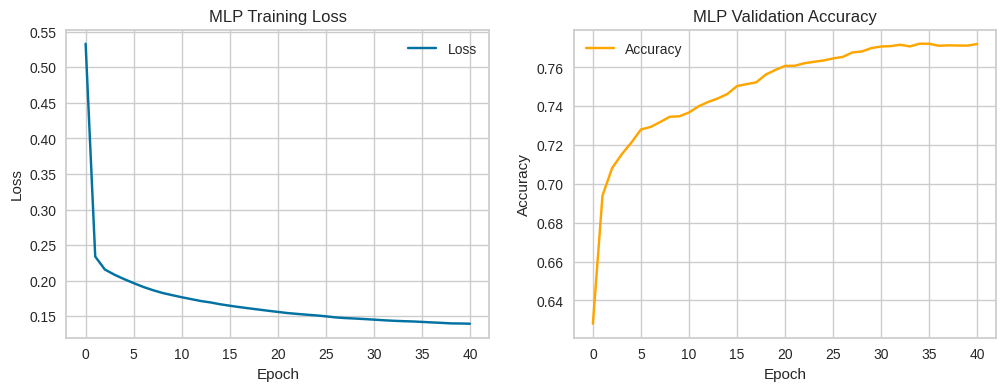

In [15]:
# plt metrics side-by-side
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].plot(pipe.named_steps["mlpregressor"].loss_curve_)
axes[0].set_title("MLP Training Loss")
axes[0].legend(["Loss"])
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

axes[1].plot(pipe.named_steps["mlpregressor"].validation_scores_, color="orange")
axes[1].set_title("MLP Validation Accuracy")
axes[1].legend(["Accuracy"])
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy");